# PHAS0102 HPC Project - Stage 2

by Fahad Chohan <br>
Student Number: 15019455 <br>
Date - 28/03/2019

## Introduction

For stage 2 of the project, we will be solving the following parabolic equation:
$$
u_t(x, y) = \nabla \cdot \left(\sigma(x, y)\nabla\right)u(x,y)
$$ 

with space domain and boundary conditions of:
-  $(x, y)\in [0, 1]\times [0, 1]$
- $u(x,y,t) = 0$ on $\Gamma_D$ for $t \geq 0 $
- $u(x,y,t) = g(x,y)$ for $t=0$


We use a forward difference scheme to approximate $u_t(x, y)$:

$$
u_t(x, y)\approx \frac{u(x, y, t+\Delta t) - u(x, y, t)}{\Delta t}
$$

Using the forward time scheme we can create an iterative relationship as follows:

$$
u(x, y, t+\Delta t) \approx [1 + \Delta t \ \nabla \cdot \left(\sigma(x, y)\nabla\right) ] u(x, y)
$$

The operator $\nabla \cdot \left(\sigma(x, y)\nabla\right)u(x,y)$ is approximated by the same standard centered finite difference scheme as in stage 1:

$$
\nabla \cdot \left(\sigma(x, y)\nabla\right)u \approx \frac{\left(\sigma_{i+1/2, j}\frac{\left(u_{i+1,j} - u_{i,j}\right)}{h}\right) - \left(\sigma_{i-1/2, j}\frac{\left(u_{i,j} - u_{i-1,j}\right)}{h}\right)}{h} + \frac{\left(\sigma_{i, j+1/2}\frac{\left(u_{i,j+1} - u_{i,j}\right)}{h}\right) - \left(\sigma_{i, j-1/2}\frac{\left(u_{i,j} - u_{i,j-1}\right)}{h}\right)}{h}
$$

where $u_{i, j} := u(x_i, y_j)$ and $h$ is the grid spacing. We approximate $\sigma_{i+1/2,j}\approx \frac{1}{2}\left(\sigma_{i+1,j} + \sigma_{i, j}\right)$ and $\sigma_{i,j+1/2}\approx \frac{1}{2}\left(\sigma_{i,j+1} + \sigma_{i, j}\right)$.

## Initialisation and Classes

In [2]:
# Import modules.
import pyopencl as cl
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
import time


In [3]:
# Timer class which is used to time iterations.
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [4]:
# Variable class containing grid dimension and sigma values.
class variable(object):
    def __init__(self, disp=True):
        self._disp = disp
        
        # Number of grid points for x and y dimensions respectively.
        self.n_x = 300
        self.n_y = 300
        
        # Sigma function created from random distribution of numbers.
        S = np.random.normal(0, 0.1, self.n_x*self.n_y).reshape(self.n_x,self.n_y)
        sig = np.empty_like(S)
        
        for i in range(self.n_y):
            for j in range(self.n_x):
                sig[i][j] = np.e**(-S[i][j])
        
        self.sigma = sig
        
# Shortcut for calling class.
var = variable()       

## Matrix Vector Multiplication Function and LinearOperator

In [5]:
# Creates context and queue for opencl kernel
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [6]:
def opencl_mv(u):
    """
    Applies a standard centered finite difference scheme via openCL onto an input vector 'u'
    
    """
    kernel = """
    __kernel void FD_kernel(__global double *u,
                            __global double *sigma,
                            __global double *Au
                            ){
    
        int gidcol = get_global_id(0);
        int gidrow = get_global_id(1);
        int gid = gidcol + n_x*gidrow;
        
        double h = 1.0/n_x;
                
        bool t = gid < n_x;
        bool b = gid > n_x*(n_y-1);
        bool l = gid % n_x == 0;
        bool r = (gid+1) % n_x == 0;
                
        if(t+b+l+r == 0){
            Au[gid] = ( 1.0/(h*h) )* 
                (0.5*(sigma[gid] + sigma[gid+1])*(u[gid+1] - u[gid])
                    - 0.5*(sigma[gid] + sigma[gid-1])*(u[gid] - u[gid-1])
                        + 0.5*(sigma[gid] + sigma[gid + n_x])*(u[gid + n_x] - u[gid])
                            - 0.5*(sigma[gid] + sigma[gid - n_x])*(u[gid] - u[gid - n_x]));            
        }    
        
    }
    
    
    
    """
    queue.finish()

    # Initialise arrays for use in opencl buffer with dataype 'double'.
    sigma = np.array(var.sigma).astype('double')
    u = np.array(u).astype('double')
    Au = u.copy().astype('double')    

    # Mem flags
    mf = cl.mem_flags

    # Create buffers to read and write.
    sigma_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=sigma)
    u_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=u)
    Au_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_WRITE, hostbuf = Au)

    # Build program and set values for n_x and n_y in opencl kernel.
    prg = cl.Program(ctx, kernel)
    prg.build(options=['-D', 'n_x={0}'.format(var.n_x), '-D', 'n_y={0}'.format(var.n_y)])

    # Execute opencl kernel.
    prg.FD_kernel(queue, (var.n_x,var.n_y), (1, 1), u_buffer, sigma_buffer, Au_buffer)

    # Ensure all opencl kernel executions are complete.
    queue.finish()

    # Extract output data.
    cl.enqueue_copy(queue, Au, Au_buffer)

    queue.finish()

    # Return matrix vector product.
    return Au
    

## $g(x,y)$ and $\sigma(x,y)$

g(x,y):


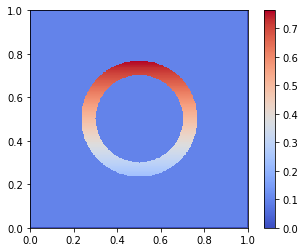

In [7]:
# Initial input array for u at t=0.
g = np.zeros([var.n_y,var.n_x])

for j in range(1, var.n_y - 1):
    for i in range(1, var.n_x - 1):
        g[j][i] = 0.1

for j in range(1, var.n_y - 1):
    for i in range(1, var.n_x - 1):
        if((i-150)**2 + (j-150)**2 > 60**2):
            if((i-150)**2 + (j-150)**2 < 80**2):
                g[j][i] = j/300.0


print('g(x,y):')

# Show visual representation.
plt.imshow(g, extent=[0,1,0,1], origin='lower', cmap='coolwarm')
plt.colorbar()
plt.show()

sigma(x,y):


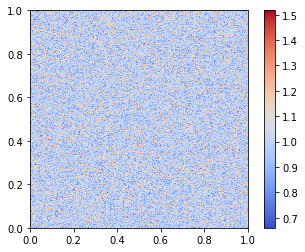

In [8]:
# Show visual representation for sigma.
print('sigma(x,y):')
plt.imshow(var.sigma , extent=[0,1,0,1], origin='lower', cmap='coolwarm')
plt.colorbar()
plt.show()

## Execution

In [9]:
# Create list which stores values of u(x,y) for each time iteration and number of iterations to perform, nIter
nIter = 10
DATA = [0]*(nIter + 1)

We can find the maximum usable $\Delta t$ before the values for $u(x,y)$ blow up by noting that from our forward time scheme relationship we have eigenvalues $1 + \Delta t \lambda_k$ where $\lambda_k$ are the eigenvalues for the operator $\nabla \cdot \left(\sigma(x, y)\nabla\right)$. Therefore, we require that $|1+\Delta t \lambda_k| < 1$ for all eigenvalues. From this one determines that we must have $\lambda_{km} < \frac{2}{\Delta t}$, where $\lambda_{km}$ is size of the largest eigenvalue. This is implemented in max_timestep() below.

In [10]:
def max_timestep():
    '''
    Calculates and returns maximum usable dt value.
    '''
    # Create identity matrix with number of grid points as u(x,y).
    I = np.identity(var.n_x)
    
    # Perform opencl_mv() matrix multiplacation on identity matrix.
    A = opencl_mv(I)
    
    # Find minimum eigenvalue for matrix A.
    lambda_km = np.min(np.linalg.eig(A)[0])
    
    # Return maximum usable dt value
    return -2.0/lambda_km

In [11]:
def do_timestep(u):
    '''
    Function which performs next time step on current iterate 'u'
    '''
    # Find value for u_t(x,y).
    du_dt = opencl_mv(u.ravel())

    # Find next iteration of u(x,y).
    u_tplus1 = dt*du_dt + u.ravel()
    
    # Return next iteration for u(x,y)
    return u_tplus1

In [12]:
def iteration_loop(nIter):
    '''
    Function which performs nIter number of timesteps by calling do_timestep() function and stores iterations in list DATA[]
    '''
    # Input initial values for u(x,y) at t=0.
    DATA[0] = g

    # Perform nIter number of time iterations using do_timestep() function and store in DATA[] list.
    for t in range(1, nIter + 1):
        DATA[t] = do_timestep(DATA[t-1])

In [13]:
def show_iterations(nIter, stp = 1):
    '''
    Prints visual representation of each iteration of u(x,y) and output timestamp and iteration number. 
    Variable 'stp' can be used to determine after how many iterations the matrix should be printed to screen.
    '''
    
    # Loop over and print u(x,y) array for t=0 and all iterations up to nIter.
    for t in range(0, int(nIter/stp) + 1):
        plt.figure()
        plt.imshow(DATA[t*stp].reshape(var.n_x,var.n_y), extent=[0,1,0,1], origin='lower', cmap='coolwarm')
        plt.colorbar()
        plt.show()
        print('Iteration - ', stp*t)
        print('Time - ', t*stp*dt)
        print('------------------------------------------')

In [14]:
# Use a value for dt which is 90% of the max usable calculated value.
dt = 0.9*max_timestep()

# Perform 10 time iterations and time.
with Timer() as T:
    iteration_loop(nIter)

# Print total time taken for 10 iterations.
print('Total time taken for', nIter ,'iterations:', T.interval)
print('dt value: ', dt)

Total time taken for 10 iterations: 0.21002435684204102
dt value:  2.382599827962904e-06


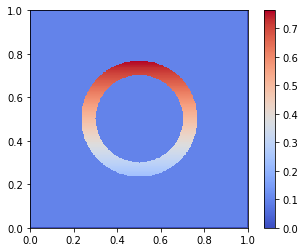

Iteration -  0
Time -  0.0
------------------------------------------


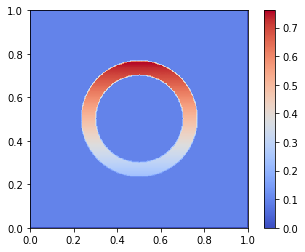

Iteration -  1
Time -  2.382599827962904e-06
------------------------------------------


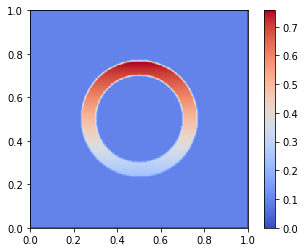

Iteration -  2
Time -  4.765199655925808e-06
------------------------------------------


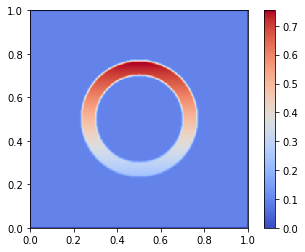

Iteration -  3
Time -  7.1477994838887115e-06
------------------------------------------


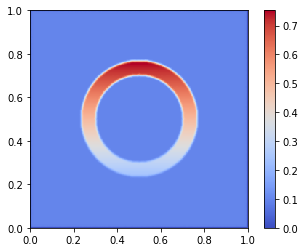

Iteration -  4
Time -  9.530399311851615e-06
------------------------------------------


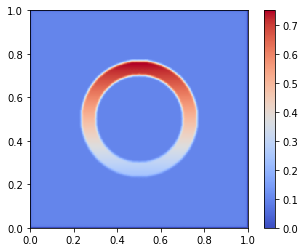

Iteration -  5
Time -  1.191299913981452e-05
------------------------------------------


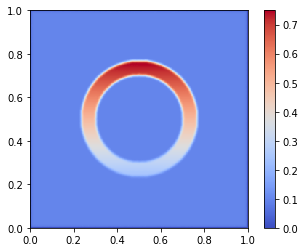

Iteration -  6
Time -  1.4295598967777423e-05
------------------------------------------


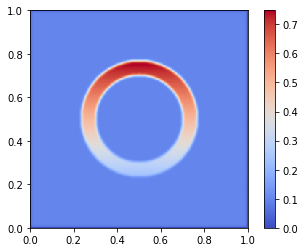

Iteration -  7
Time -  1.6678198795740325e-05
------------------------------------------


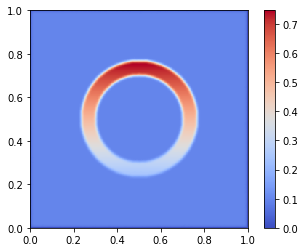

Iteration -  8
Time -  1.906079862370323e-05
------------------------------------------


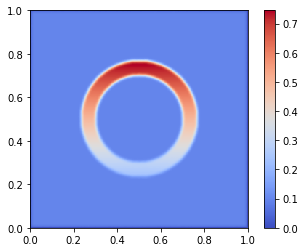

Iteration -  9
Time -  2.1443398451666136e-05
------------------------------------------


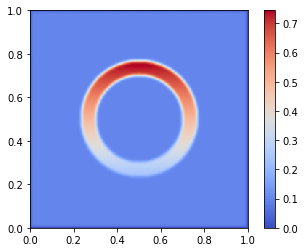

Iteration -  10
Time -  2.382599827962904e-05
------------------------------------------


In [15]:
# Show 10 initial and subsequent 10 iterations for u(x,y).
show_iterations(nIter, 1)